In [1]:
from sklearn.metrics import *
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.init as init
import importlib
import data
import agente_cnn
import torch
import torch.nn as nn
import torch.nn.functional as F
from itertools import islice
import agente_knn
from torch.utils.data import Subset
import agente_mlp
from sklearn.neighbors import KNeighborsClassifier
from torchvision.transforms import ToPILImage
from lime import lime_image
from PIL import Image
from skimage.segmentation import mark_boundaries

importlib.reload(data)
importlib.reload(agente_cnn)
importlib.reload(agente_knn)
importlib.reload(agente_mlp)

c:\Users\Adrian\anaconda3\envs\AA\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'agente_mlp' from 'd:\\Universidad\\Aprendizaje-Automatico-y-Big-Data\\Practica5\\agente_mlp.py'>

In [2]:
path = "./UTKFace"
idx = 100
GENERO = ('Hombre','Mujer')
RAZA = ('Blanco','Negro','Asiático','Indio','Otros')

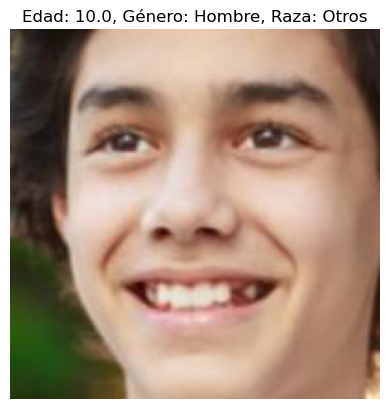

In [3]:
# Adaptamos las imagenes a un dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = data.Dataset(path, transform=transform)  # Pasamos las imagenes a la estructura de datos
imagen, age,gender,race = dataset.__getitem__(idx)
imagen_np = imagen.permute(1, 2, 0).numpy()  # Convertir (C, H, W) a (H, W, C)

imagen_np = imagen_np * 0.5 + 0.5  # Revertir la normalización

# Mostrar la imagen
plt.imshow(imagen_np)
plt.title(f"Edad: {age}, Género: {GENERO[gender]}, Raza: {RAZA[race]}")  # Mostrar información adicional si la tienes
plt.axis('off')  # Ocultar los ejes
plt.show()

In [44]:
class DenzelWashington(nn.Module):
    def __init__(self,output_layers):
        super().__init__()

        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.pool2 = nn.MaxPool2d(4, 4)
       
        self.fc1 = nn.Linear(12 * 11 * 11, 500)
        self.fcout = nn.Linear(500, output_layers)

        self.apply(self._init_weights)  # Aplicar la inicialización de pesos

    def _init_weights(self, m):
        """Inicializa los pesos de la red"""
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            init.normal_(m.weight, mean=0.0, std=0.02)
            if m.bias is not None:
                init.constant_(m.bias, 0)

    def forward(self, x):

        x = self.pool1(x) #3 fotos 100x100
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = self.fcout(x)
        return x


#Modelo edad
DWEdad = DenzelWashington(output_layers=1)
mseLoss = nn.MSELoss()

#Modelo Genero
DWGenero = DenzelWashington(output_layers=2)
entropyLossGen = nn.CrossEntropyLoss()

#Modelo raza
DWRaza = DenzelWashington(output_layers=5)
entropyLossRaza = nn.CrossEntropyLoss()

agenteDW = agente_cnn.Agente(modeloEdad=DWEdad,
                         modeloGenero=DWGenero,
                         modeloRaza=DWRaza,
                         criterioEdad=mseLoss,
                         criterioGenero=entropyLossGen,
                         criterioRaza=entropyLossRaza,
                         device="cpu",
                         lr = 0.0001)

agenteDW.modeloEdad.load_state_dict(torch.load('./Modelos/DWEdad.pth',map_location=torch.device('cpu')))
agenteDW.modeloGenero.load_state_dict(torch.load('./Modelos/DWGenero.pth',map_location=torch.device('cpu')))
agenteDW.modeloRaza.load_state_dict(torch.load('./Modelos/DWRaza.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

In [45]:
device = "cpu"

In [46]:
class LolaLolita(nn.Module):
    def __init__(self,output_layers):
        super().__init__()

        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=6, kernel_size=3)
        self.conv2 = nn.Conv2d(6, 12, 4)
        self.conv3 = nn.Conv2d(12,24,6)
        self.conv4 =  nn.Conv2d(24,48,16)
        self.pool2 = nn.MaxPool2d(3, 3)
       
        self.fc1 = nn.Linear(48 * 100, 1200)
        self.fc2 = nn.Linear(1200, 850)
        self.fcout = nn.Linear(850, output_layers)

        self.apply(self._init_weights)  # Aplicar la inicialización de pesos

    def _init_weights(self, m):
        """Inicializa los pesos de la red"""
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            init.normal_(m.weight, mean=0.0, std=0.02)
            if m.bias is not None:
                init.constant_(m.bias, 0)

    def forward(self, x):

        x = self.pool1(x) 
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(F.relu(self.conv3(x)))
        x = self.pool2(F.relu(self.conv4(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fcout(x)
        return x
    
#Modelo edad
LLEdad = LolaLolita(output_layers=1)
mseLoss = nn.MSELoss()

#Modelo Genero
LLGenero = LolaLolita(output_layers=2)
entropyLossGen = nn.CrossEntropyLoss()

#Modelo raza
LLRaza = LolaLolita(output_layers=5)
entropyLossRaza = nn.CrossEntropyLoss()

agenteLL= agente_cnn.Agente(modeloEdad=LLEdad,
                         modeloGenero=LLGenero,
                         modeloRaza=LLRaza,
                         criterioEdad=mseLoss,
                         criterioGenero=entropyLossGen,
                         criterioRaza=entropyLossRaza,
                         device="cpu",
                         lr = 0.00001)
agenteLL.modeloEdad.load_state_dict(torch.load('./Modelos/LLEdad.pth',map_location=torch.device('cpu')))
agenteLL.modeloGenero.load_state_dict(torch.load('./Modelos/LLGenero.pth',map_location=torch.device('cpu')))
agenteLL.modeloRaza.load_state_dict(torch.load('./Modelos/LLRaza.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

In [25]:
modelo_knn_genero = data.recuperar_modelo('entrenamientoGeneroModelo3')

Modelo cargado desde entrenamientoGeneroModelo3


In [26]:
modelo_knn_raza = data.recuperar_modelo('entrenamientoRazaModelo3')

Modelo cargado desde entrenamientoRazaModelo3


In [27]:
modelo_knn_edad = data.recuperar_modelo('entrenamientoEdadModelo3')

Modelo cargado desde entrenamientoEdadModelo3


In [47]:
class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP, self).__init__()
        # Definir las capas del MLP
        self.fc1 = nn.Linear(input_size, 512)  # Capa de entrada -> 512 unidades
        self.fc2 = nn.Linear(512, 256)         # Capa oculta -> 256 unidades
        self.fc3 = nn.Linear(256, num_classes) # Capa de salida -> número de clases

    def forward(self, x):
        # Aplanar las imágenes de tamaño (batch_size, 3, 64, 64) a (batch_size, 12288)
        x = x.view(x.size(0), -1)  # Aplanar las imágenes a un vector 1D por imagen
        x = F.relu(self.fc1(x))    # Capa 1 -> ReLU
        x = F.relu(self.fc2(x))    # Capa 2 -> ReLU
        x = self.fc3(x)            # Capa 3 -> Salida
        return x
    

mlp_raza = MLP(input_size=64*64*3, num_classes=5)
mlp_raza.load_state_dict(torch.load('./Modelos/NapoleonRaza.pth'))
mlp_raza.eval()  # Para ponerlo en modo evaluación
mlp_edad = MLP(input_size=64*64*3, num_classes=10)
mlp_edad.load_state_dict(torch.load('./Modelos/NapoleonEdad.pth'))
mlp_edad.eval()  # Para ponerlo en modo evaluación
mlp_genero = MLP(input_size=64*64*3, num_classes=2)
mlp_genero.load_state_dict(torch.load('./Modelos/NapoleonGenero.pth'))
mlp_genero.eval()  # Para ponerlo en modo evaluación

MLP(
  (fc1): Linear(in_features=12288, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
)

## Modelo 1: LIME

In [48]:
# Adaptamos las imagenes a un dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = data.Dataset(path, transform=transform)  # Pasamos las imagenes a la estructura de datos
imagen, age,gender,race = dataset.__getitem__(idx)

In [49]:
def predict(imagen, modelo, device, transform=None):
    modelo.eval()

    # Si la imagen es un tensor, la usamos directamente; si es PIL, la transformamos
    if isinstance(imagen, torch.Tensor):
        img_tensor = imagen.unsqueeze(0).to(device)
    else:
        if transform is None:
            transform = transforms.Compose([
                transforms.Resize((100, 100)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
            ])
        img_tensor = transform(imagen).unsqueeze(0).to(device)

    with torch.no_grad():
        salida = modelo(img_tensor)  # Obtener la salida del modelo
        probs = F.softmax(salida, dim=1).cpu().numpy()[0]  # Obtener las probabilidades
        clase_idx = probs.argmax()  # Obtener el índice de la clase con mayor probabilidad
        return clase_idx  # Devolver el índice de la clase


In [50]:
def lime_explanation(imagen_original, imagen_lime, modelo, num_clases, device, transform, num_features=5, num_samples=1000):
    # Asegurarse de que imagen_para_lime sea PIL
    if isinstance(imagen_lime, torch.Tensor):
        imagen_lime = ToPILImage()(imagen_lime.cpu())
    img_np = np.array(imagen_lime)  # Convertir a NumPy array

    # Función de predicción para LIME
    def predict_fn(images):
        modelo.eval()
        inputs = [transform(Image.fromarray(img)).unsqueeze(0).to(device) for img in images]
        inputs = torch.cat(inputs)
        with torch.no_grad():
            outputs = modelo(inputs)
            if num_clases == 1:
                return outputs.cpu().numpy()
            else:
                probs = torch.nn.functional.softmax(outputs, dim=1)
                return probs.cpu().numpy()

    # Crear el explicador y generar la explicación
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        image=img_np,
        classifier_fn=predict_fn,
        top_labels=1,
        hide_color=0,
        num_samples=num_samples
    )

    # Obtener imagen explicada
    temp, mask = explanation.get_image_and_mask(
        label=explanation.top_labels[0],
        positive_only=True,
        hide_rest=False,
        num_features=num_features,
        min_weight=0.0
    )

    # Visualización: imagen original y explicación lado a lado
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(imagen_original)
    ax[0].axis('off')
    ax[0].set_title('Imagen original')

    ax[1].imshow(mark_boundaries(temp / 255.0, mask))
    ax[1].axis('off')
    ax[1].set_title('Explicación LIME')

    plt.tight_layout()
    plt.show()

    return explanation


### Modelo 1: Denzel Washington

In [57]:
clase = predict(imagen, modelo=agenteDW.modeloGenero, device="cpu")
print ('La prediccion es la clase: ', GENERO[clase])

La prediccion es la clase:  Hombre


100%|██████████| 1000/1000 [00:01<00:00, 581.02it/s]


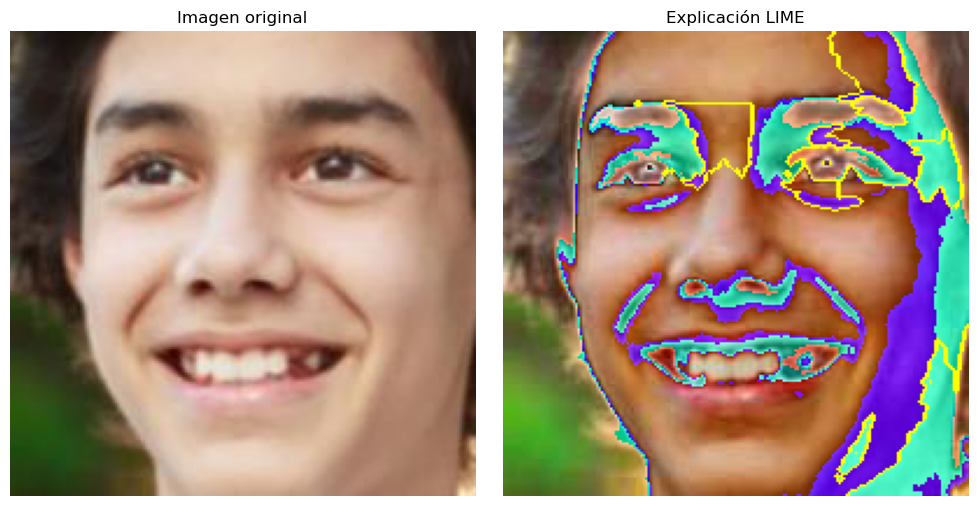

In [58]:
lime_explanation(
    imagen_original=imagen_np,              # Imagen original desnormalizada en NumPy (para visualización)
    imagen_lime=imagen,                # Imagen como tensor o PIL para que LIME trabaje
    modelo=agenteDW.modeloGenero,
    num_clases=2,
    device=device,
    transform=transform,
    num_samples=1000
)

In [59]:
clase = predict(imagen, modelo=agenteDW.modeloRaza, device=device)
print ('La prediccion es la clase: ', RAZA[clase])

La prediccion es la clase:  Otros


100%|██████████| 1000/1000 [00:01<00:00, 582.61it/s]


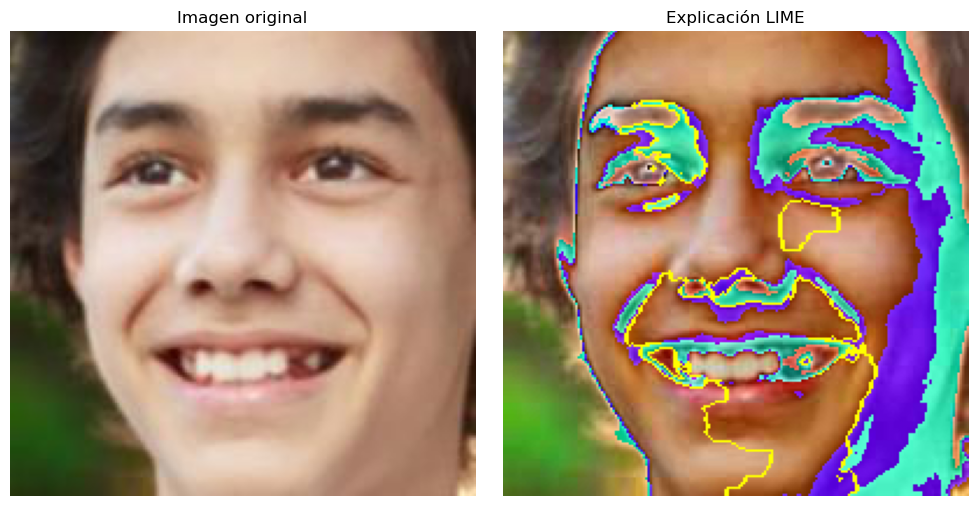

In [60]:
lime_explanation(
    imagen_original=imagen_np,              # Imagen original desnormalizada en NumPy (para visualización)
    imagen_lime=imagen,                # Imagen como tensor o PIL para que LIME trabaje
    modelo=agenteDW.modeloRaza,
    num_clases=5,
    device=device,
    transform=transform,
    num_samples=1000
)

In [61]:
clase = predict(imagen, modelo=agenteDW.modeloEdad, device=device)
print ('La prediccion es la clase el grupo: ', clase)

La prediccion es la clase el grupo:  0


100%|██████████| 1000/1000 [00:01<00:00, 602.13it/s]


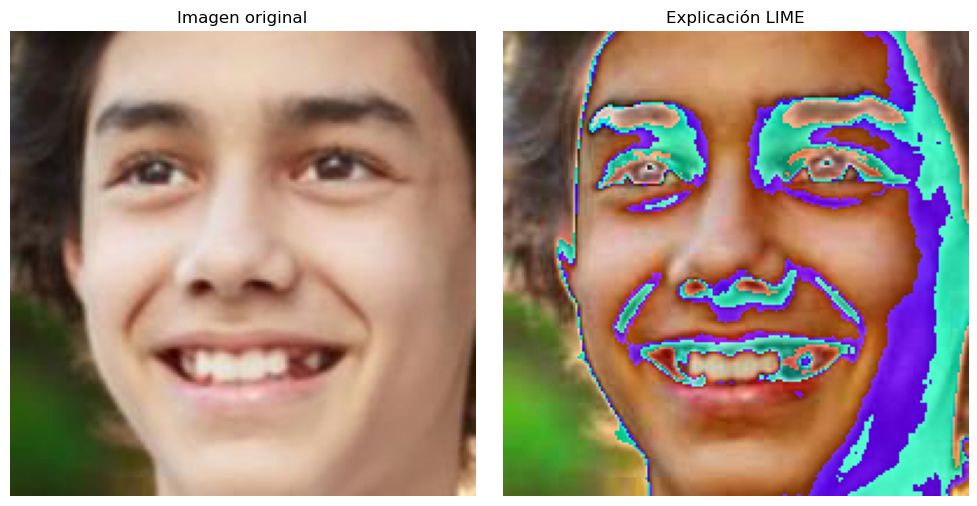

In [62]:
lime_explanation(
    imagen_original=imagen_np,              # Imagen original desnormalizada en NumPy (para visualización)
    imagen_lime=imagen,                # Imagen como tensor o PIL para que LIME trabaje
    modelo=agenteDW.modeloEdad,
    num_clases=10,
    device=device,
    transform=transform,
    num_samples=1000
)

## Modelo 2 : Lola Lolita

In [37]:
#Esto sirve para ver en que dispositivo se entrena.
#GPU(cuda) es mas rapido que CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Entrenando en: {device}")

Entrenando en: cpu


In [63]:
clase = predict(imagen, modelo=agenteLL.modeloGenero, device=device)
print ('La prediccion es la clase: ', GENERO[clase])

La prediccion es la clase:  Hombre


100%|██████████| 1000/1000 [00:03<00:00, 310.02it/s]


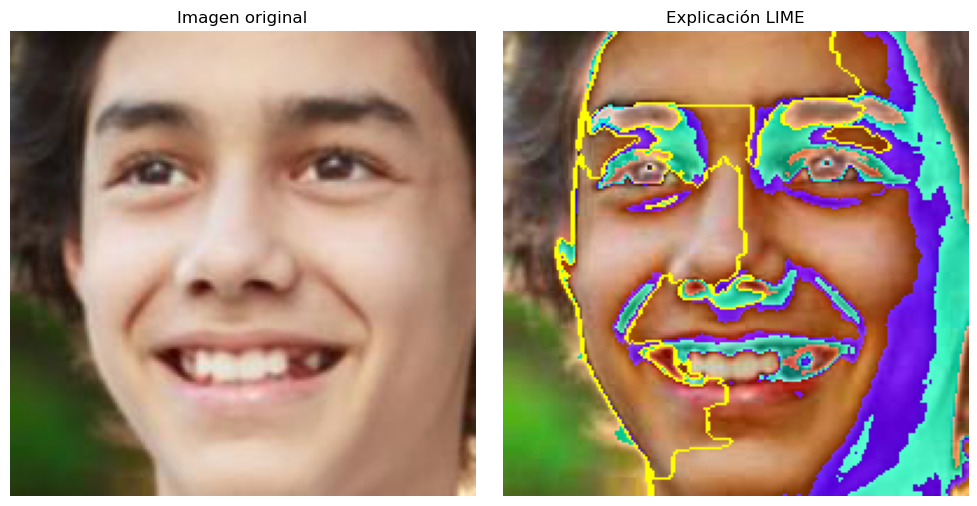

In [64]:
lime_explanation(
    imagen_original=imagen_np,              # Imagen original desnormalizada en NumPy (para visualización)
    imagen_lime=imagen,                # Imagen como tensor o PIL para que LIME trabaje
    modelo=agenteLL.modeloGenero,
    num_clases=2,
    device=device,
    transform=transform,
    num_samples=1000
)

In [65]:
clase = predict(imagen, modelo=agenteLL.modeloRaza, device=device)
print ('La prediccion es la clase: ', RAZA[clase])

La prediccion es la clase:  Otros


100%|██████████| 1000/1000 [00:03<00:00, 311.19it/s]


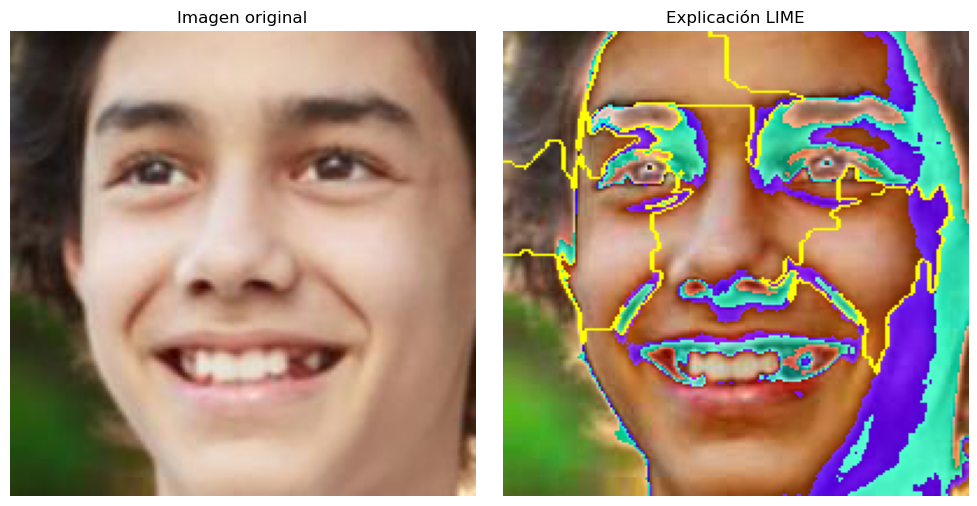

In [66]:
lime_explanation(
    imagen_original=imagen_np,              # Imagen original desnormalizada en NumPy (para visualización)
    imagen_lime=imagen,                # Imagen como tensor o PIL para que LIME trabaje
    modelo=agenteLL.modeloRaza,
    num_clases=5,
    device=device,
    transform=transform,
    num_samples=1000
)

In [67]:
clase = predict(imagen, modelo=agenteLL.modeloEdad, device=device)
print ('La prediccion es el grupo: ', clase)

La prediccion es el grupo:  0


100%|██████████| 1000/1000 [00:03<00:00, 308.47it/s]


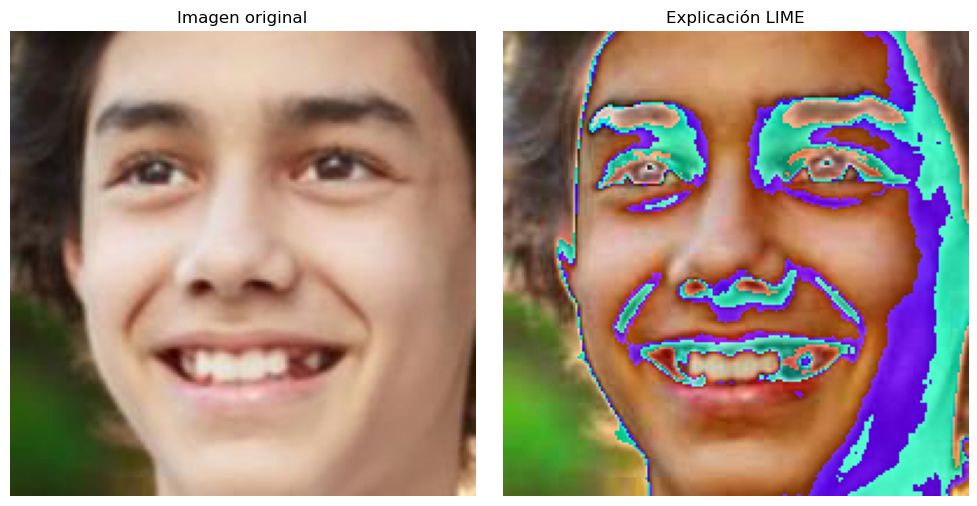

In [68]:
lime_explanation(
    imagen_original=imagen_np,              # Imagen original desnormalizada en NumPy (para visualización)
    imagen_lime=imagen,                # Imagen como tensor o PIL para que LIME trabaje
    modelo=agenteLL.modeloEdad,
    num_clases=10,
    device=device,
    transform=transform,
    num_samples=1000
)

### Modelo 3: Almeida

In [69]:
importlib.reload(agente_knn)

<module 'agente_knn' from 'd:\\Universidad\\Aprendizaje-Automatico-y-Big-Data\\Practica5\\agente_knn.py'>

In [70]:
# Adaptamos las imagenes a un dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = data.Dataset(path, transform=transform,target_transform=data.clasificarEdad)  # Pasamos las imagenes a la estructura de datos
imagen, age,gender,race = dataset.__getitem__(idx)

In [71]:
prediccion = agente_knn.predecir_instancia(modelo_knn_genero,imagen, etiqueta='genero')
print ('La prediccion es la clase: ', GENERO[prediccion])

NameError: name 'modelo_knn_genero' is not defined

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Etiquetas disponibles en la explicación: dict_keys([np.int64(1)])


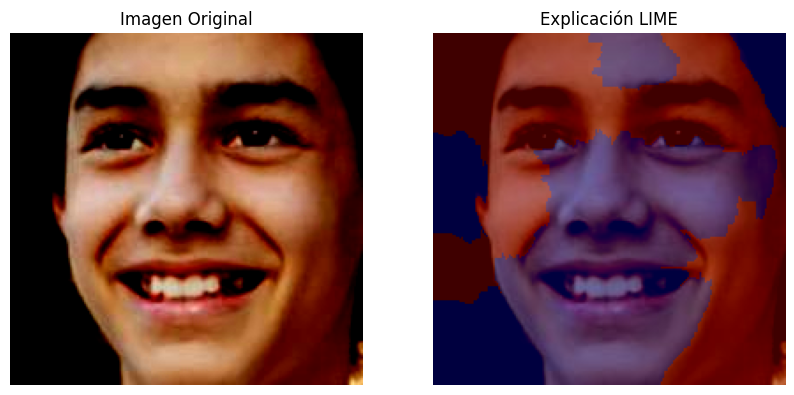

In [51]:
agente_knn.lime_explain_and_visualize(modelo_knn_genero, imagen, device='cpu', num_samples=1000)

In [ ]:
prediccion = agente_knn.predecir_instancia(modelo_knn_raza,imagen, etiqueta='raza')
print ('La prediccion es la clase: ', RAZA[prediccion])

La prediccion es la clase:  Blanco


  0%|          | 0/1000 [00:00<?, ?it/s]

Etiquetas disponibles en la explicación: dict_keys([np.int64(0)])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


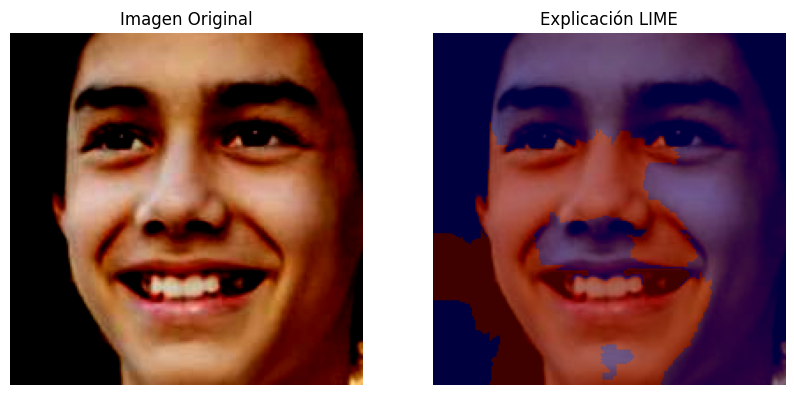

In [ ]:
agente_knn.lime_explain_and_visualize(modelo_knn_raza, imagen, device='cpu', num_samples=1000)

In [ ]:
prediccion = agente_knn.predecir_instancia(modelo_knn_edad,imagen, etiqueta='edad')
print ('La prediccion es la clase: ', prediccion)

La prediccion es la clase:  3


  0%|          | 0/1000 [00:00<?, ?it/s]

Etiquetas disponibles en la explicación: dict_keys([np.int64(2)])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


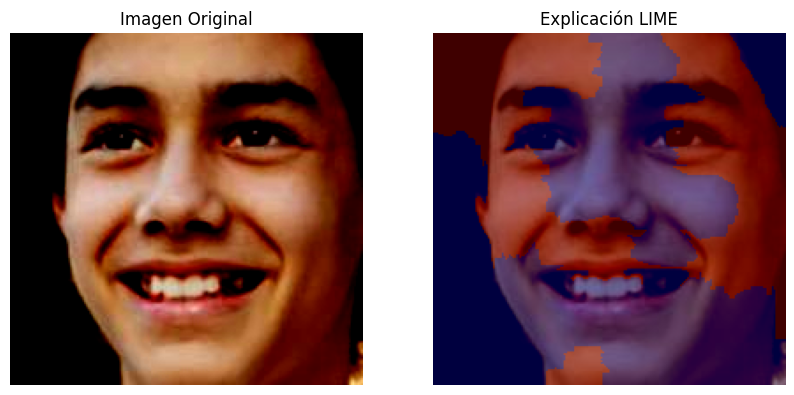

In [ ]:
agente_knn.lime_explain_and_visualize(modelo_knn_edad, imagen, device='cpu', num_samples=1000)

### Modelo 4: Napoleón

In [72]:
importlib.reload(agente_mlp)

<module 'agente_mlp' from 'd:\\Universidad\\Aprendizaje-Automatico-y-Big-Data\\Practica5\\agente_mlp.py'>

In [74]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Redimensionar la imagen
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset = data.Dataset(path, transform=transform)  # Pasamos las imagenes a la estructura de datos
imagen, age,gender,race = dataset.__getitem__(idx)

In [75]:
prediccion = agente_mlp.predecir_instancia_mlp(mlp_raza,imagen,etiqueta='raza')
print('La clase predicha es ',RAZA[prediccion])

La clase predicha es  Asiático


100%|██████████| 1000/1000 [00:00<00:00, 4344.81it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.90588236].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529411792755127..1.0].


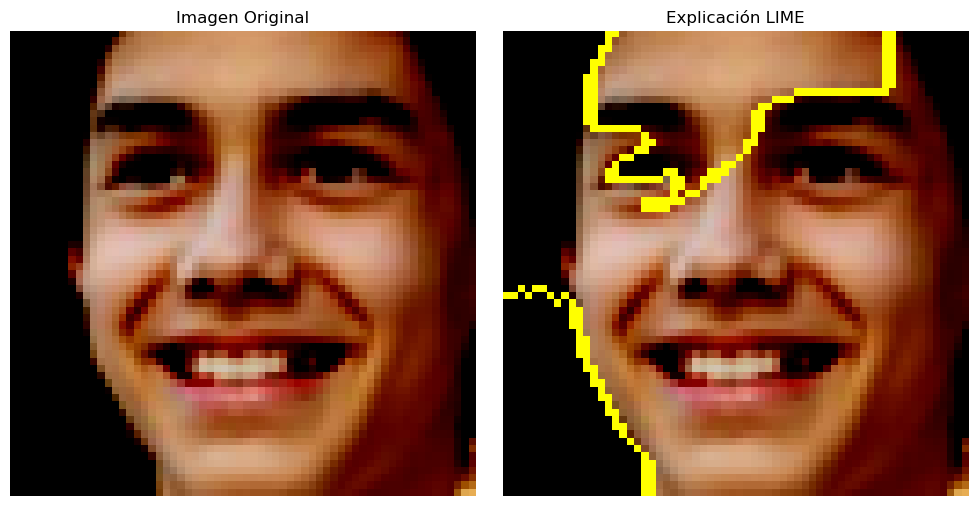

In [76]:
agente_mlp.lime_explain_and_visualize_mlp(mlp_raza, imagen, device='cpu', num_samples=1000)

In [77]:
prediccion = agente_mlp.predecir_instancia_mlp(mlp_edad,imagen,etiqueta='edad')
print('La clase predicha es ',prediccion)

La clase predicha es  1


100%|██████████| 1000/1000 [00:00<00:00, 4191.99it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.90588236].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529411792755127..1.0].


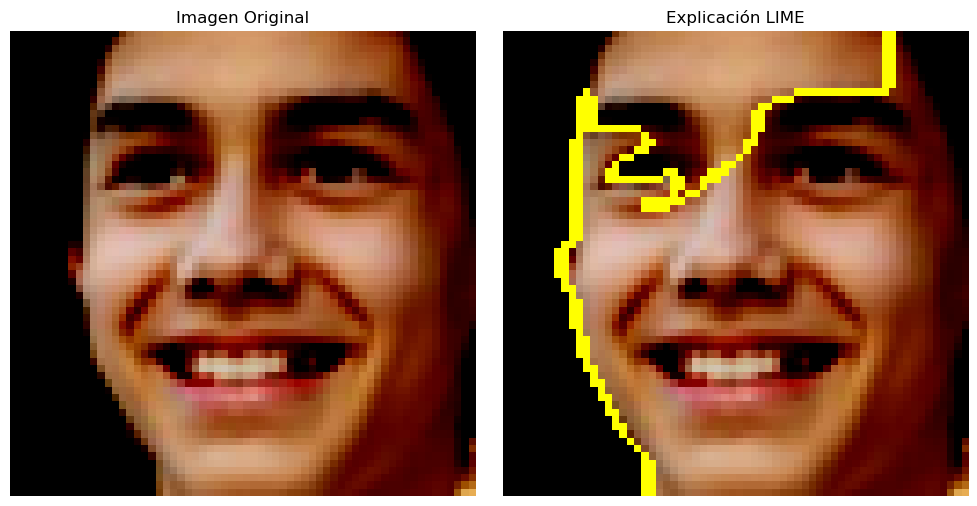

In [78]:
agente_mlp.lime_explain_and_visualize_mlp(mlp_edad, imagen, device='cpu', num_samples=1000)

In [79]:
prediccion = agente_mlp.predecir_instancia_mlp(mlp_genero,imagen,etiqueta='edad')
print('La clase predicha es ',GENERO[prediccion])

La clase predicha es  Hombre


100%|██████████| 1000/1000 [00:00<00:00, 4423.09it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.90588236].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529411792755127..1.0].


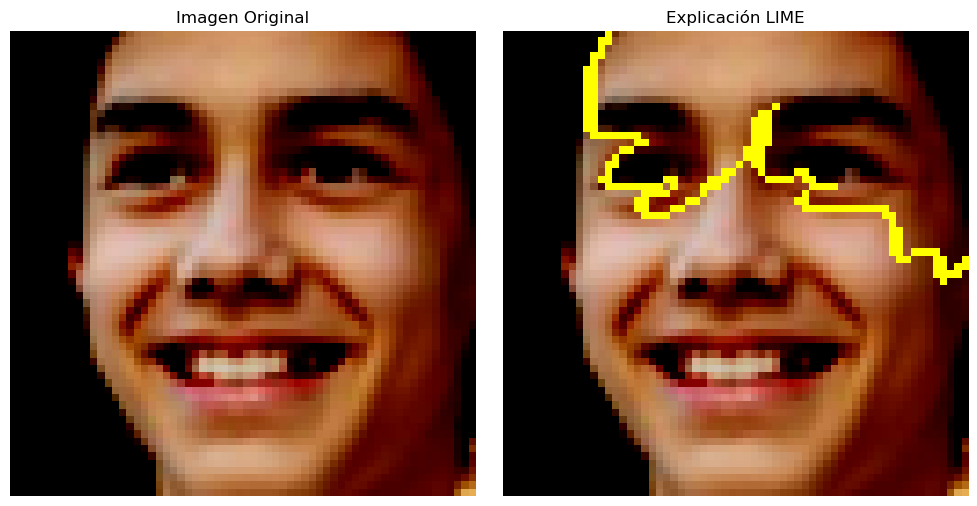

In [80]:
agente_mlp.lime_explain_and_visualize_mlp(mlp_genero, imagen, device='cpu', num_samples=1000)